In [6]:
from kdg import kdf
from kdg.utils import generate_gaussian_parity, plot_2dsim
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import numpy as np

### Visualize the data
The data is bounded within [-1,1] limit.

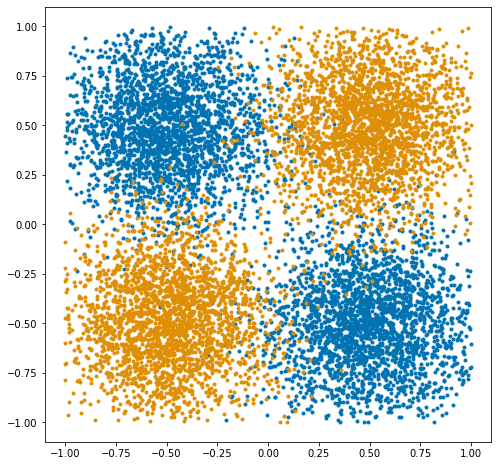

In [7]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

### Define the model with one tree

In [8]:
def experiment(sample):
    X, y = generate_gaussian_parity(sample, cluster_std=0.5)
    X_test, y_test = generate_gaussian_parity(1000, cluster_std=0.5)
    
    model_kdf = kdf(kwargs={'n_estimators':1})
    model_kdf.fit(X, y)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)

    return error_kdf, error_rf

In [9]:
mc_reps = 50
sample_size = np.logspace(
        np.log10(10),
        np.log10(500000),
        num=10,
        endpoint=True,
        dtype=int
)

In [10]:
err_rf_med = []
err_rf_25_quantile = []
err_rf_75_quantile = []

err_kdf_med = []
err_kdf_25_quantile = []
err_kdf_75_quantile = []
for sample in sample_size:
    print('Doing sample %d'%sample)

    res_kdf = Parallel(n_jobs=-1)(
                delayed(experiment)(
                sample
                ) for _ in range(mc_reps)
            )

    err_kdf = []
    err_rf = []

    for ii in range(mc_reps):
        err_kdf.append(
                res_kdf[ii][0]
            )
        err_rf.append(
                res_kdf[ii][1]
            )

    err_rf_med.append(np.median(err_rf))
    err_rf_25_quantile.append(
            np.quantile(err_rf,[.25])[0]
        )
    err_rf_75_quantile.append(
        np.quantile(err_rf,[.75])[0]
    )
    err_kdf_med.append(np.median(err_kdf))
    err_kdf_25_quantile.append(
            np.quantile(err_kdf,[.25])[0]
        )
    err_kdf_75_quantile.append(
        np.quantile(err_kdf,[.75])[0]
    )

Doing sample 10


exception calling callback for <Future at 0x7fd7388c9550 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/site-packages/ipykernel/codeutil.py", line 27, in code_ctor
    return types.CodeType(*args)
TypeError: an integer is required (got type bytes)
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, 

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(sample_size, err_kdf_med, c="r", label='KDT')
ax.plot(sample_size, err_rf_med, c="k", label='Decision Tree')

ax.fill_between(sample_size, err_kdf_25_quantile, err_kdf_75_quantile, facecolor='r', alpha=.3)
ax.fill_between(sample_size, err_rf_25_quantile, err_rf_75_quantile, facecolor='k', alpha=.3)

ax.set_xscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('Generalization error')